In [154]:
library(limma) 
library(edgeR) 
library(ggplot2)
library(dplyr)
library('Glimma') 
library(Rtsne)
library(RColorBrewer)
library(gplots)

>The code from this file is used to compute the results for the part 3.2 of the project: **RNA-Seq Data Analysis**.


The datasets used in this file are :
1. df ( columns= IDC or ILC samples; rows= quantitative expression of a given gene).
2. gene_size (contains gene_id, gene name and gene lenght of each gene computed using "rentrez" package).
3. df_samples (contains sample_id, the intrinsic type and the histlogical type associated to these samples).

# 3.2.1 Data processing

## Reading the data

> A DGE list is created in this part to read the data.

In [155]:
#upload the data for the right samples (only IDC enc ILC)
df <- read.table("data/data_rna2.txt")

dim(df)
head(df)

[1] 20440   617

gene_id   TCGA.A1.A0SD.01 TCGA.A1.A0SE.01 TCGA.A1.A0SF.01 TCGA.A1.A0SI.01
0 100134869 11.3241           4.4426         10.7401          2.9782       
1     10357 60.2630         153.1452        141.1933         63.5491       
2    155060 83.6986          74.7018        314.4482        149.7940       
3     26823  0.3308           0.0000          0.0000          0.2943       
4    280660  0.0000           0.0000          0.0000          0.0000       
5    340602  0.6616           0.0000          0.0000          0.2943       
  TCGA.A1.A0SJ.01 TCGA.A1.A0SM.01 TCGA.A1.A0SN.01 TCGA.A1.A0SP.01
0   4.9419          7.6484          5.6992          9.4309       
1 134.8733        119.4760         95.0898        190.5983       
2  63.6488         80.8081        108.4028        140.0949       
3   0.3658          0.3157          0.0000          0.0000       
4   0.0000          0.0000          0.0000          0.0000       
5   0.0000          0.0000          0.0000          0.0000       
  TCGA.A1.A0SQ.01 ... TCGA.LL.A440.01 TCGA.LL.A441.01 TCGA.LL.A5YM.01
0  1.0368         ...  13.1811         13.1371          0.0000       
1 41.5532         ... 136.0213        214.6517        101.2865       
2 75.8447         ... 708.0590        637.6447        130.9387       
3  0.0000         ...   1.0001          0.9447          0.0000       
4  0.0000         ...   0.0000          0.0000          0.0000       
5  0.0000         ...   0.3334          3.7786          0.5095       
  TCGA.LL.A5YN.01 TCGA.LL.A5YO.01 TCGA.LL.A5YP.01 TCGA.LQ.A4E4.01
0   2.9624          3.6899          6.3020         14.1288       
1 100.3083        278.5626        206.4376        117.0300       
2 367.2936        165.7717        103.9783        307.2124       
3   0.5225          0.0000          0.0000          0.9974       
4   0.0000          0.0000          0.0000          0.0000       
5   2.0899         10.4640          2.7125          0.0000       
  TCGA.MS.A51U.01 TCGA.OL.A66I.01 TCGA.OL.A66K.01
0   7.9343          1.2603          4.3892       
1 150.6834        158.3599        106.3475       
2 540.4278        210.7460        554.5539       
3   1.5649          0.4173          1.2434       
4   0.0000          0.0000          0.0000       
5   0.5216          2.0866          0.0000

In [156]:
#upload the data with gene size
gene_size <- read.table("data/data_gene_name2.txt",header=TRUE,sep=',')
gene_size$X<-c()

dim(gene_size)

[1] 20440     3

In [157]:
#create a list of gene availables in the gene_size document
gene_list<- gene_size$gene_id

#filter to keep only the genes with available size
df<-df %>% filter(gene_id %in% gene_list)

#check the dimension
dim(df)


[1] 20440   617

In [158]:
#reset the index
rownames(df) <- c()

#set the gene id as the new index
rownames(df)<-df$gene_id

#remove the column gene id from the dataframe
df$gene_id<-NULL


In [159]:
#dataframe containing the type of cancer for each patient (IDC or ILC)
df_samples <- read.table("data/data_samples_3.txt",sep=',',header=TRUE)
df_samples$group<- as.factor(df_samples$histological_type)
df_samples$cancer_type<-as.factor(df_samples$cancer_type)
df_samples$X<-NULL
df_samples$histological_type<-NULL
df_samples <-df_samples[order(df_samples$sample_id),]

dim(df_samples)

[1] 616   3

In [160]:
#create a DGE list with all the necessary information
x<-DGEList(df,genes=gene_size,samples=df_samples)
x

An object of class "DGEList"
$counts
          TCGA.A1.A0SD.01 TCGA.A1.A0SE.01 TCGA.A1.A0SF.01 TCGA.A1.A0SI.01
100134869         11.3241          4.4426         10.7401          2.9782
10357             60.2630        153.1452        141.1933         63.5491
155060            83.6986         74.7018        314.4482        149.7940
26823              0.3308          0.0000          0.0000          0.2943
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A1.A0SJ.01 TCGA.A1.A0SM.01 TCGA.A1.A0SN.01 TCGA.A1.A0SP.01
100134869          4.9419          7.6484          5.6992          9.4309
10357            134.8733        119.4760         95.0898        190.5983
155060            63.6488         80.8081        108.4028        140.0949
26823              0.3658          0.3157          0.0000          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A1.A0SQ.01 TCGA.A2.A04P.01 TCGA.A2.A04Q.01 TCGA.A2.A04R.01
100134869          1.0368          3.4440          3.8334         11.5874
10357             41.5532        244.2064        185.5958        119.8406
155060            75.8447        329.8755        354.8014        262.2476
26823              0.0000          0.5187          0.3857          1.8111
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A04T.01 TCGA.A2.A04U.01 TCGA.A2.A04V.01 TCGA.A2.A04X.01
100134869         23.9972          0.5195          5.2638          2.8476
10357            232.6558        411.4041        166.4412         70.5055
155060           165.8698         78.9713        132.8173         45.7781
26823              0.3477          0.0000          0.0000          0.3605
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0CK.01 TCGA.A2.A0CL.01 TCGA.A2.A0CM.01 TCGA.A2.A0CO.01
100134869          2.6384          7.7650          3.8260          6.4292
10357            113.6646         91.2602        238.3801         97.5164
155060           263.0303        229.4292        125.9952        281.5666
26823              0.0000          0.7413          0.0000          2.0888
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0CP.01 TCGA.A2.A0CQ.01 TCGA.A2.A0CR.01 TCGA.A2.A0CS.01
100134869          4.5107          5.7526          4.9047          2.6627
10357             96.5147         86.5958        115.1087         77.7942
155060           247.3190        400.5360        201.0924         27.2266
26823              0.0000          1.7865          0.0000          0.4615
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0CU.01 TCGA.A2.A0CV.01 TCGA.A2.A0CW.01 TCGA.A2.A0D0.01
100134869          5.2157          5.8939          2.9027          1.5527
10357             73.5739         63.6091        133.4560        234.9835
155060           176.4032        102.2903        290.2716        118.2043
26823              0.3818          0.0000          0.0000          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0D2.01 TCGA.A2.A0D3.01 TCGA.A2.A0D4.01 TCGA.A2.A0EN.01
100134869          9.3920          4.4688          2.6412          5.2178
10357            177.6492         88.3701        164.8202         92.5505
155060           164.8494        194.0996        147.5009        169.0843
26823              0.0000          0.9673          0.2662          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0EO.01 TCGA.A2.A0EP.01 TCGA.A2.A0EQ.01 TCGA.A2.A0ET.01
100134869          2.9878          6.1063          2.9596          6.4382
10357            107.2489        141.1230        198.8601        122.1587
155060            75.3228        404.9837        123.9378        254.6046
26823              0.3587          0.3322          0.8290          0.8126
280660             0.0000          0.0000

## Row scale transformation to CPM

In [161]:
lcpm<-cpm(x,log=TRUE)

## Gene filtering


In [162]:
#statistics the data

L <- mean(x$samples$lib.size) * 1e-6
M <- median(x$samples$lib.size) * 1e-6
c(L, M)

[1] 19.05765 18.94148

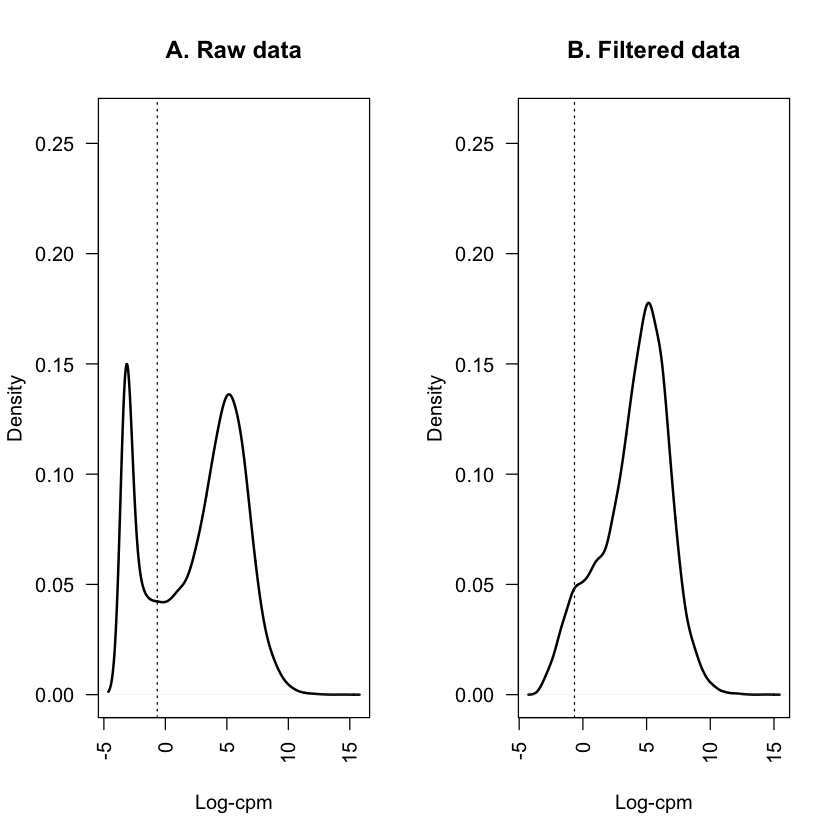

In [163]:
#DISTRIBUTION OF THE DATA BEFORE AND AFTER FILTERTING (filterby function)

#png(file="fig/filtered.png",width=3500,height=2000,res=500)

par(mfrow=c(1,1))

lcpm.cutoff <- log2(10/M + 2/L)
#col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))

plot(density(lcpm[,1]), col='black', lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

keep.exprs <- filterByExpr(x, group=x$samples$group)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col='black', lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

#dev.off()

In [ ]:
dim(x)
print("15996 genes were kept after the filtering procedure.")

## Normalization: TMM Methods

In [165]:
#factors for the TMM method
x <- calcNormFactors(x, method = "TMM")

In [166]:
#lcmp<-cpm(x,log=TRUE)
subset_after<-as.data.frame( lcpm[,1:10])

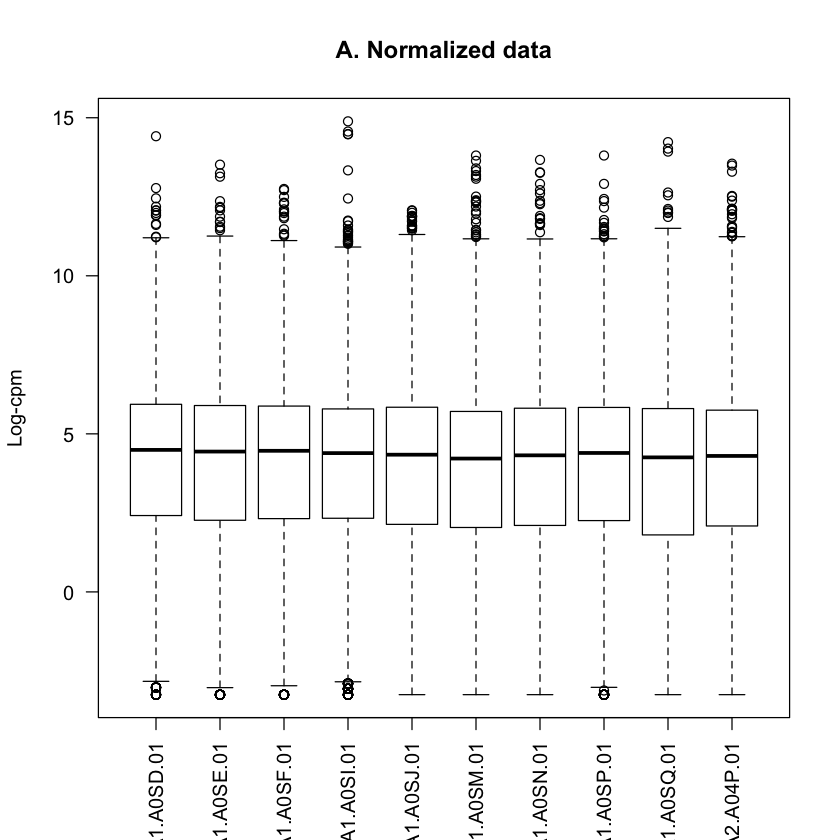

In [167]:
boxplot(subset_after, las=2, main="",col="white")
title(main="A. Normalized data", ylab="Log-cpm")

# 3.2.2 Exploratory Data Analysis

## Principal Component Analysis

In [168]:
lcpm.pca <- prcomp(t(lcpm), center = TRUE) 

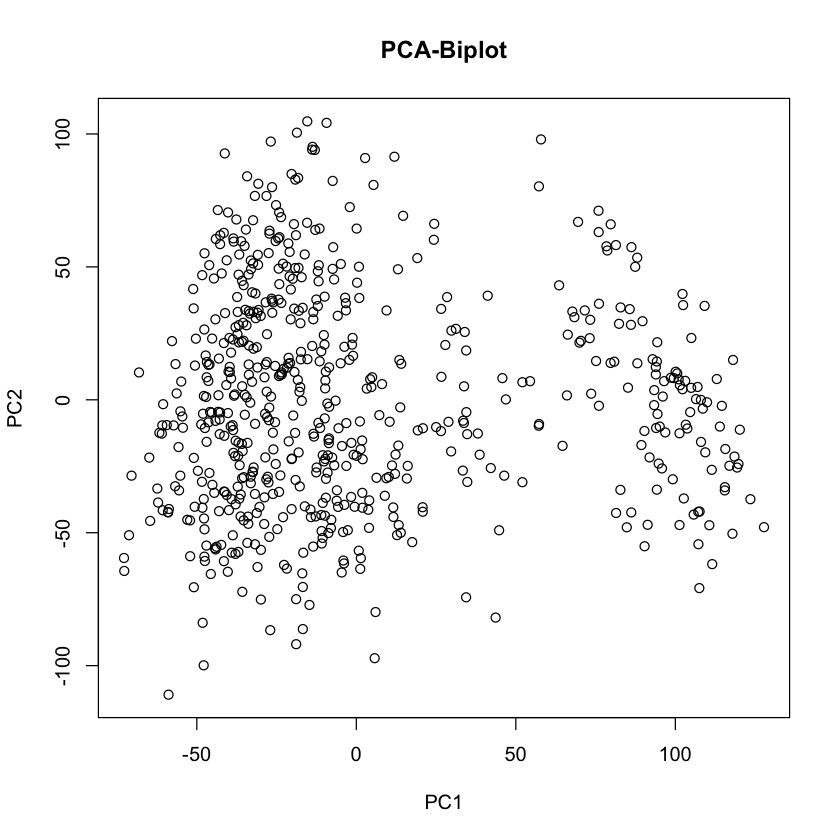

In [169]:
#plot the two first principal components
plot(lcpm.pca$x[,1], lcpm.pca$x[,2],main="PCA-Biplot",xlab="PC1",ylab="PC2")

In [170]:
#new dataset with the information about the samples
cluster_name<-x$samples
head(cluster_name)

group lib.size norm.factors sample_id       cancer_type
TCGA.A1.A0SD.01 IDC   18546079 1.0770846    TCGA-A1-A0SD-01 IDC_LumA   
TCGA.A1.A0SE.01 ILC   18836070 1.0368735    TCGA-A1-A0SE-01 ILC_LumA   
TCGA.A1.A0SF.01 IDC   18867893 1.0391126    TCGA-A1-A0SF-01 IDC_LumA   
TCGA.A1.A0SI.01 IDC   20343089 0.9764456    TCGA-A1-A0SI-01 IDC_LumB   
TCGA.A1.A0SJ.01 IDC   19600587 0.9614996    TCGA-A1-A0SJ-01 IDC_LumA   
TCGA.A1.A0SM.01 IDC   21455641 0.8673246    TCGA-A1-A0SM-01 IDC_LumA

In [171]:
#keep only the column of interest
cluster_name$lib.size<-NULL
cluster_name$norm.factors<-NULL
cluster_name$sample_id<-NULL
head(cluster_name)

group cancer_type
TCGA.A1.A0SD.01 IDC   IDC_LumA   
TCGA.A1.A0SE.01 ILC   ILC_LumA   
TCGA.A1.A0SF.01 IDC   IDC_LumA   
TCGA.A1.A0SI.01 IDC   IDC_LumB   
TCGA.A1.A0SJ.01 IDC   IDC_LumA   
TCGA.A1.A0SM.01 IDC   IDC_LumA

In [172]:
#integrate the group in the pca data
lcpm.pca$group<-cluster_name
head(lcpm.pca$group)

group cancer_type
TCGA.A1.A0SD.01 IDC   IDC_LumA   
TCGA.A1.A0SE.01 ILC   ILC_LumA   
TCGA.A1.A0SF.01 IDC   IDC_LumA   
TCGA.A1.A0SI.01 IDC   IDC_LumB   
TCGA.A1.A0SJ.01 IDC   IDC_LumA   
TCGA.A1.A0SM.01 IDC   IDC_LumA

In [173]:
#create the dataset for the final pca plot
data_plot <- data.frame(lcpm.pca$x[,1], lcpm.pca$x[,2])
colnames(data_plot)=c('PCA1', 'PCA2')

In [174]:
data_plot$group<-cluster_name$group

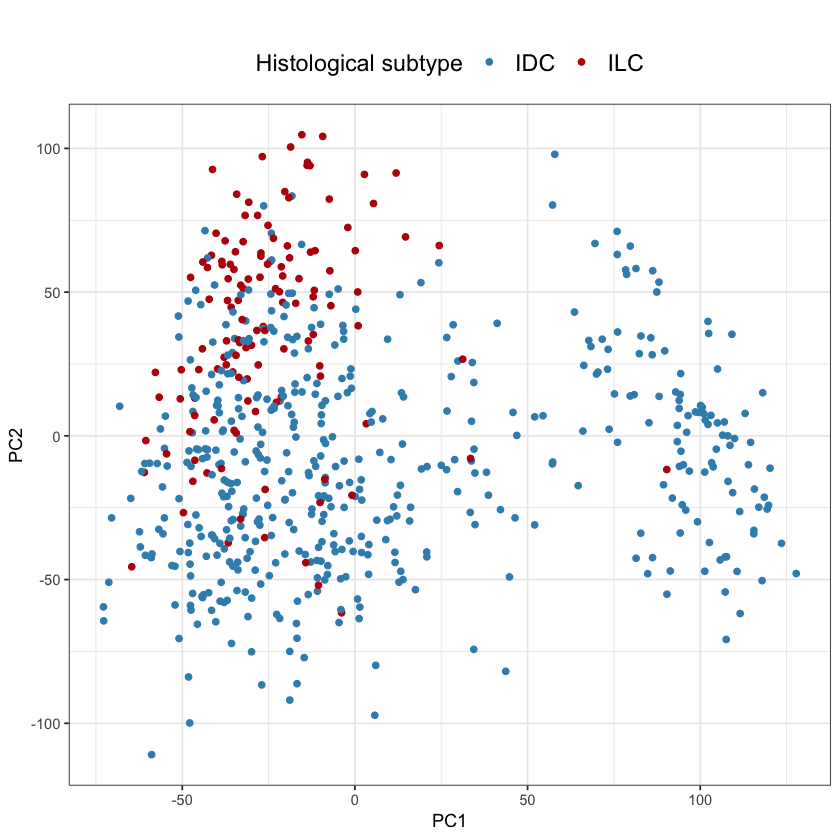

In [175]:
#png(file="fig/pca.png",width=2000,height=2000,res=400)
ggplot(data_plot, aes(x=PCA1, y=PCA2, color=group)) + geom_point()+
  ggtitle("") +xlab("PC1")+ ylab("PC2")+
  theme( 
    plot.title = element_text(color="black", size=12, face="bold",hjust =1/2),
    axis.title.x = element_text(color="black", size=10),
    axis.title.y = element_text(color="black", size=10))+theme_bw() + theme(legend.position='top', legend.box = "horizontal",legend.title = element_text(size=14), 
           legend.text = element_text(size=14)) + 
  scale_color_manual(name="Histological subtype", labels = c("IDC","ILC"), values = c("IDC"="#3A8EBA", "ILC"="#BB0B0B"))
#dev.off()

##  t-Distributed Stochastic Neighbor Embedding

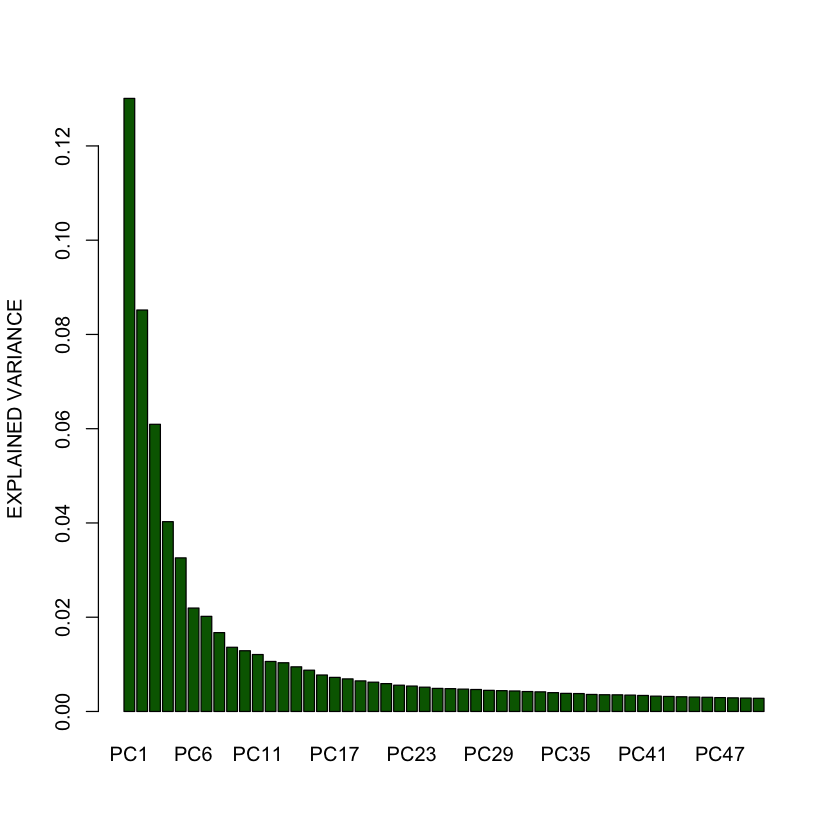

In [176]:
#dimenstionality reduction with PCA algorithm
PC <- prcomp(t(lcpm), center=TRUE, scale=FALSE)

#computation of the variance explained by each PC
expl_var <- PC$sdev^2/sum(PC$sdev^2)

#plot
barplot(expl_var[1:50], ylab="EXPLAINED VARIANCE",names.arg=paste0("PC",seq(1:50)), col="darkgreen")

In [177]:
#computation of the variance explained by chance
N_perm <- 10
expl_var_perm <- matrix(NA, ncol = length(PC$sdev), nrow = N_perm)
for(k in 1:N_perm)
{
  expr_perm <- apply(lcpm,2,sample)
  PC_perm <- prcomp(t(expr_perm), center=TRUE, scale=FALSE)
  expl_var_perm[k,] <- PC_perm$sdev^2/sum(PC_perm$sdev^2)
}


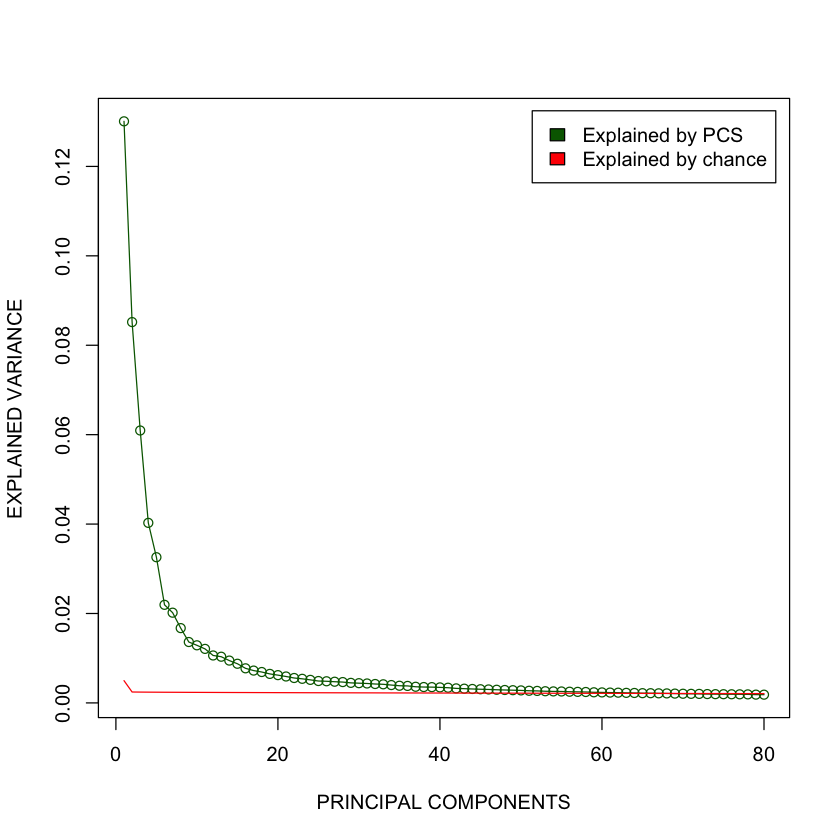

In [178]:
#png(file="fig/medium.png",width=1000,height=800,res=200)
plot(expl_var[1:80]~seq(1:80), ylab="EXPLAINED VARIANCE", col="darkgreen", type='o', xlab="PRINCIPAL COMPONENTS")
lines(colMeans(expl_var_perm)[1:80]~seq(1:80),col="red")
legend("topright", c("Explained by PCS", "Explained by chance"),fill=c("darkgreen","red"), inset=0.02)
#dev.off()


[1] "The optimal number of PC:"


[1] 68

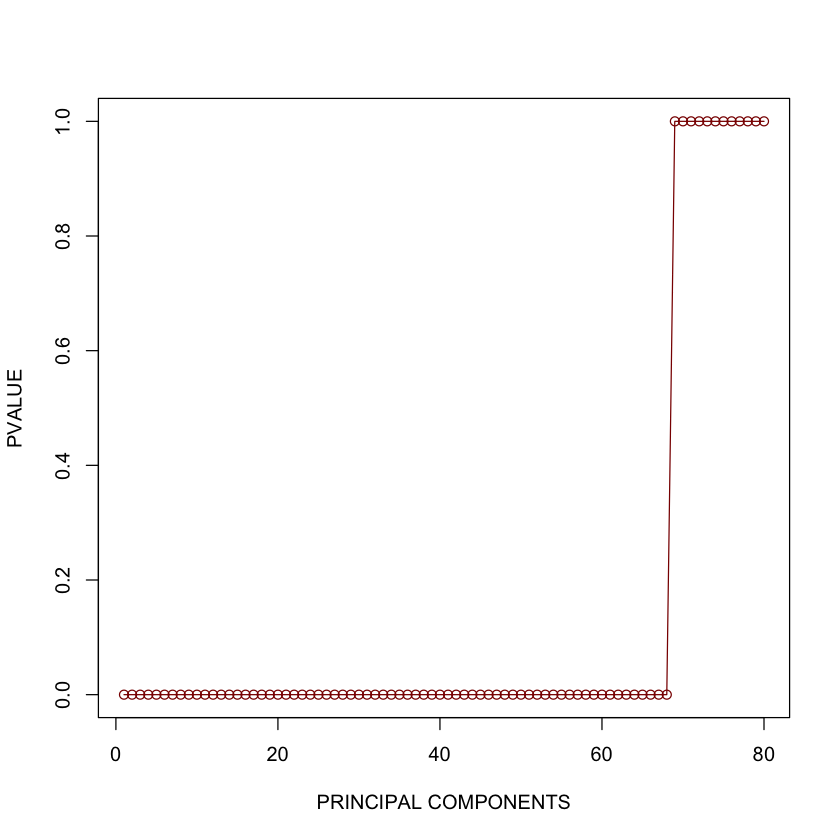

In [179]:
#computation of the p-value
pval <- apply(t(expl_var_perm) >= expl_var,1,sum) / N_perm

#png(file="fig/medium2.png",width=1000,height=800,res=200)
plot(pval[1:80]~seq(1:80),col="darkred",type='o',xlab="PRINCIPAL COMPONENTS",ylab="PVALUE")
#dev.off()
optPC<-head(which(pval>=0.05),1)-1

print("The optimal number of PC:")
optPC

In [180]:
Labels<-data_plot$group
colors = c("#3A8EBA","#BB0B0B")

## tSNE  algorithm with the tuned parameters
tsne <- Rtsne(t(lcpm), dims = 2,initial_dims=optPC, perplexity=24, verbose=TRUE, max_iter = 1000)

Performing PCA
Read the 616 x 68 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 24.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.19 seconds (sparsity = 0.168489)!
Learning embedding...
Iteration 50: error is 64.370907 (50 iterations in 0.12 seconds)
Iteration 100: error is 62.793930 (50 iterations in 0.08 seconds)
Iteration 150: error is 62.784386 (50 iterations in 0.08 seconds)
Iteration 200: error is 62.775313 (50 iterations in 0.08 seconds)
Iteration 250: error is 62.775304 (50 iterations in 0.09 seconds)
Iteration 300: error is 1.386201 (50 iterations in 0.07 seconds)
Iteration 350: error is 1.295067 (50 iterations in 0.07 seconds)
Iteration 400: error is 1.270477 (50 iterations in 0.07 seconds)
Iteration 450: error is 1.256933 (50 iterations in 0.07 seconds)
Iteration 500: error is 1.248023 (50 iterations in 0.07 seconds)
Iteration 550: error is 1.244880 (50 iterations in 0.07 seconds)
Iteration 600

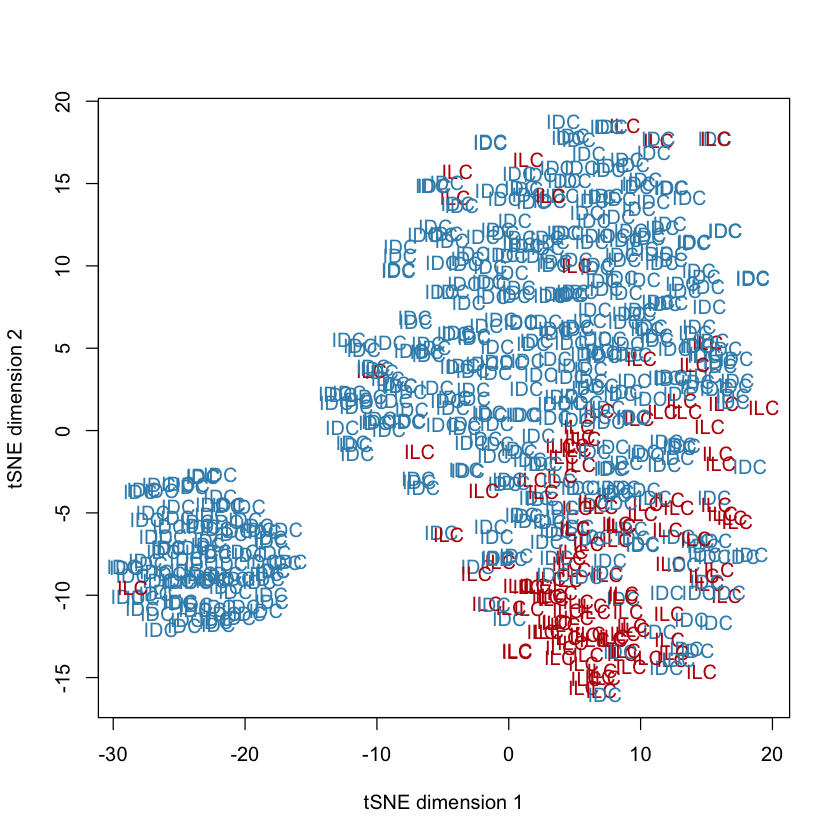

In [181]:
#plot of the tsne
#png(file="fig/stne_improved.png",width=2000,height=2000,res=280)
plot(tsne$Y, t='n', main="",xlab='tSNE dimension 1', ylab='tSNE dimension 2')
text(tsne$Y,  labels=data_plot$group,col=colors[data_plot$group])
#dev.off()

## PCA for the intrinc subtypes analysis

In [182]:
#selecting the intrinsic subtypes 
data_plot$histological_subtype<-cluster_name$group
data_plot$intrinsic_subtype<-cluster_name$cancer_type

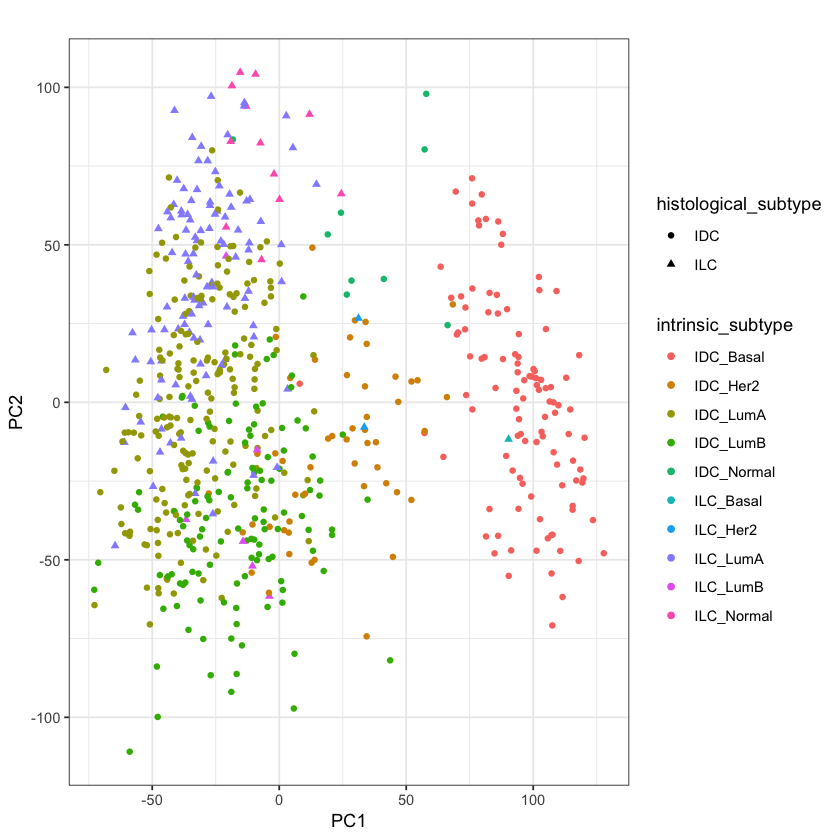

In [183]:
#png(file="fig/intrinsique_pca.png",width=3000,height=2000,res=500)
ggplot(data_plot, aes(x=PCA1, y=PCA2, color=intrinsic_subtype,shape=histological_subtype)) + geom_point()+
  ggtitle("") +xlab("PC1")+ ylab("PC2")+
  theme( 
    plot.title = element_text(color="black", size=12, face="bold",hjust =1/2),
    axis.title.x = element_text(color="black", size=10),
    axis.title.y = element_text(color="black", size=10)
  )+theme_bw() 
#dev.off()

# 3.2.3 Differential Gene Expression Analysis

In [184]:
#design matrix
design <- model.matrix(~0+x$samples$group)
colnames(design) <- c('IDC','ILC')
head(design)

IDC ILC
1 1   0  
2 0   1  
3 1   0  
4 1   0  
5 1   0  
6 1   0

In [185]:
#contraste matrix
contr.matrix <- makeContrasts(
   ILCvsIDC = ILC-IDC,
   levels = colnames(design))
contr.matrix

Contrasts
Levels ILCvsIDC
   IDC -1      
   ILC  1

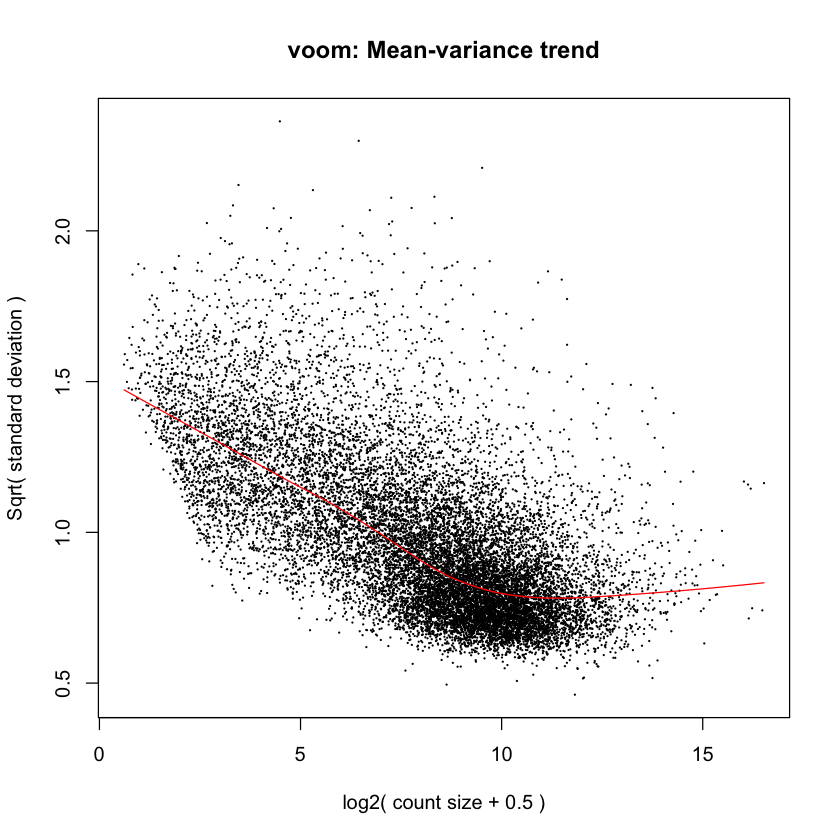

In [186]:
#The voom plot
#png(file="fig/before_var.png",width=1500,height=1000,res=200)
v <- voom(x, design, plot=TRUE)
#dev.off()

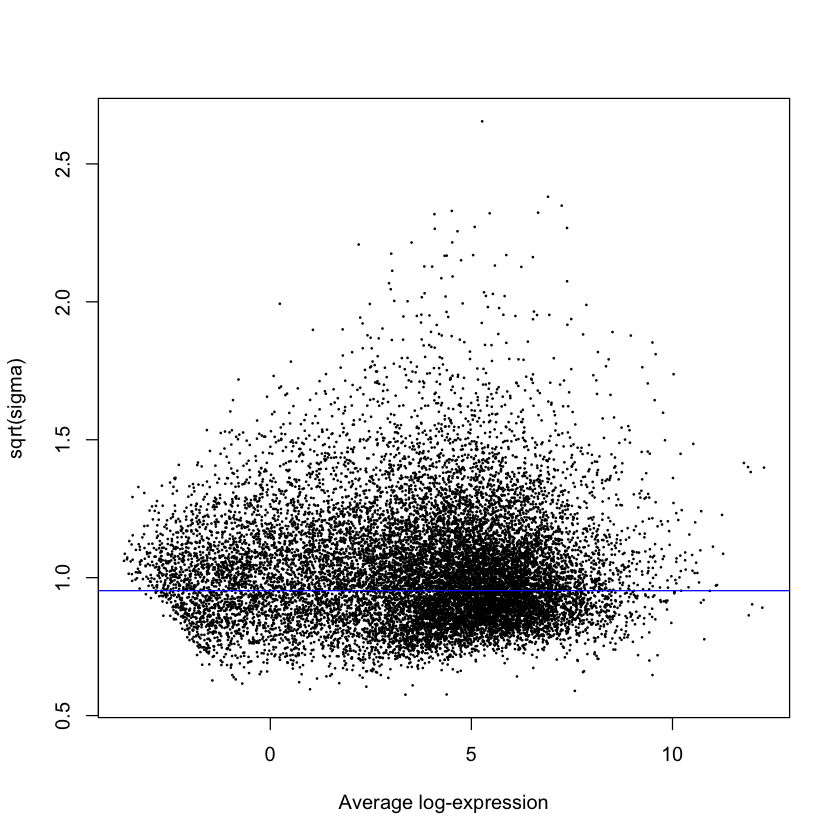

In [187]:
#fit a separate linear model to the expression values for each gene
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=contr.matrix)

#precise estimates of gene-wise variability
efit <- eBayes(vfit)

#plot
#png(file="fig/efit.png",width=3000,height=2000,res=500)
#mean is independant of the variance
plotSA(efit)
#dev.off()

In [188]:
#number of significantly up- and down-regulated
summary(decideTests(efit))

       ILCvsIDC
Down       4649
NotSig     6029
Up         5318

In [189]:
#stricter definition on significance: require log-fold-changes (log-FCs) to be above a minimum value
tfit <- treat(vfit, lfc=1)
dt <- decideTests(tfit)
summary(dt)

       ILCvsIDC
Down         28
NotSig    15734
Up          234

### Significant Differential Gene Expression 

In [190]:
#select only the genes with p<0.05 and then sort by average expression
ILC.vs.IDC <- topTreat(tfit,p.value=0.05,sort.by='AveExpr',n=Inf)

In [191]:
#logFC gives the direction
head(ILC.vs.IDC)

gene_id gene_name length logFC     AveExpr  t          P.Value     
999   999    CDH1       98245 -2.513283 8.662830 -13.416702 1.650734e-36
7832 7832    BTG2        4083  1.616148 7.600022   5.124993 1.991556e-07
1958 1958    EGR1        3824  1.540329 7.178402   3.809640 7.653162e-05
1301 1301    COL11A1   232113 -1.954625 6.531931  -3.861640 6.224361e-05
9415 9415    FADS2      51151 -2.069991 6.527860  -5.526119 2.414652e-08
3481 3481    IGF2       20491  1.527814 6.167287   3.440557 3.098032e-04
     adj.P.Val   
999  2.640515e-32
7832 2.611224e-05
1958 6.310308e-03
1301 5.185671e-03
9415 3.981935e-06
3481 2.192749e-02

### Up-regulated genes

In [192]:
#selection of only the up-regulated genes
up_regulated=ILC.vs.IDC[ILC.vs.IDC$logFC>0, ]
dim(up_regulated)
(up_regulated$gene_name)

[1] 234   8

[1] BTG2      EGR1      IGF2      COL14A1   ELN       SCGB2A2   MYH11    
  [8] MFAP4     AOC3      THBS4     LAMA2     PDK4      AGR3      FOSB     
 [15] SHROOM1   TFF1      SEMA3G    TNXB      TMPRSS3   CYP4X1    EGR3     
 [22] PLIN4     NOSTRIN   ITM2A     IGF1      ABI3BP    PTPRT     ITIH5    
 [29] CFD       TPSAB1    RAPGEF3   SAA1      SOCS2     TFAP2B    FABP4    
 [36] PTN       LIPE      WNK4      PHYHD1    COL17A1   TSPAN7    HSPB6    
 [43] OGN       ITGA7     SCGB1D2   ACKR1     NGFR      CHAD      PLIN1    
 [50] ADAMTS15  ADH1B     CHRDL1    CCL14     SCN4B     MIR143HG  CLDN5    
 [57] PDE2A     STK32B    CCL19     IL33      PEAR1     ADIPOQ    TNN      
 [64] ANKRD30A  HPX       SDPR      C7        CLDN11    NOVA1     CAPN8    
 [71] C1ORF64   CYP4Z1    MIR205HG  CYP21A2   HLF       AK5       GPD1     
 [78] PGM5      KLHDC7A   CYP4Z2P   PLD4      SELP      CCL21     BTNL9    
 [85] GP2       HMGCS2    KANK3     ADCY5     ABCB1     KIAA1456  SOWAHA   
 [92] INMT      MMRN1     NEK10     MEOX2     ABCA8     ABCA9     MEOX1    
 [99] F7        OSR1      CDO1      ABCC8     PRG4      RBP4      ADAM33   
[106] SYT9      PLAC9     MMP23B    ANGPTL1   KCNIP2    GPIHBP1   PI16     
[113] FREM1     CADM3     GSTM5     SLC19A3   ATOH8     USHBP1    LRRN4CL  
[120] TACR1     FCER1A    TIMP4     CIDEC     ALDH1A2   TAT       FAM110D  
[127] C1QTNF7   TUSC5     ATP1A2    F10       MUSTN1    SCN4A     TMEM100  
[134] VIT       GIPC2     CASQ2     VIPR2     SLC13A2   PHYHIP    GLI1     
[141] MAB21L1   VSIG2     THSD7B    SYN2      ZBTB16    C2ORF40   KLK11    
[148] SCARA5    LTC4S     DES       CTSG      NNAT      RELN      LEP      
[155] AQP7      SCN3B     CD300LG   FXYD1     ALDH1L1   SCN7A     SRL      
[162] ABCA10    TMEM132C  CYP4F35P  CBLN4     GRIK4     BMX       PLCXD3   
[169] NXNL2     GDF10     CACNA1G   SLC1A7    DNASE1L3  LUZP2     AVPR2    
[176] SCN2B     C6        SCN3A     PCK1      SIGLEC17P CYP4F8    CIDEA    
[183] LRRC4B    DLX2      ADH1C     RERGL     FIGF      TDRD10    ITIH3    
[190] LEFTY2    TPO       MYOCD     DHH       NXPH1     SSTR1     GRIA4    
[197] SLC26A3   TSLP      SLC16A12  NEFL      GFAP      CCDC178   EDN3     
[204] MASP1     CLDN19    LCN10     TNNT3     MAP1LC3C  LOC389033 PEBP4    
[211] CLEC9A    TNMD      C14ORF180 ABCB5     TMC3      KCNJ16    AFP      
[218] AQP7P1    DBX2      PROL1     CMA1      SLC7A3    TAC1      ADH1A    
[225] HEPN1     HEPACAM   IGFN1     TRHDE-AS1 MRAP      GLYAT     GRIK1-AS1
[232] ANGPTL7   CA4       NPY2R    
20440 Levels: A1BG A1BG-AS1 A1CF A2M A2M-AS1 A2ML1 A4GALT A4GNT AAAS ... ZZZ3

### Down-regulated genes

In [193]:
#selection of only the down-regulated genes
down_regulated=ILC.vs.IDC[ILC.vs.IDC$logFC<0, ]
#28
dim(down_regulated)
down_regulated$gene_name

[1] 28  8

[1] CDH1     COL11A1  FADS2    TPX2     ANLN     MYBL2    UBE2C    AURKA   
 [9] CENPE    BIRC5    MELK     NDC80    MCM10    SKA1     MMP1     ORC6    
[17] CENPA    PRR11    SGOL1    NEIL3    IBSP     CA9      KIAA0319 ACTL8   
[25] NETO1    KRT75    CASP14   SPDYC   
20440 Levels: A1BG A1BG-AS1 A1CF A2M A2M-AS1 A2ML1 A4GALT A4GNT AAAS ... ZZZ3

### Mean-Difference plot

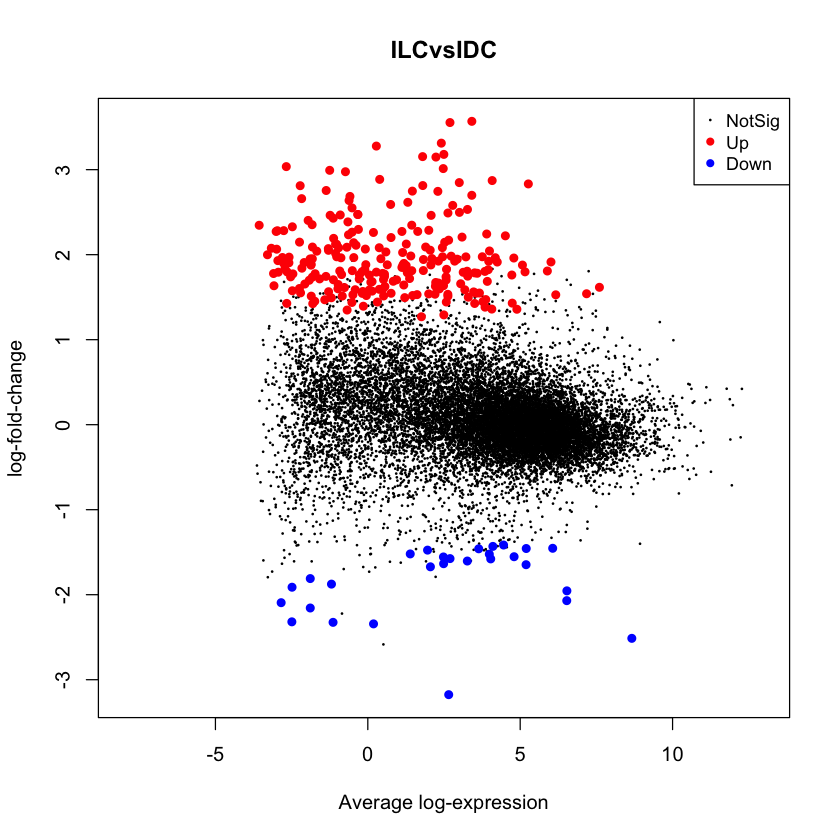

In [194]:
#png(file="fig/DEG.png",width=2000,height=1300,res=300)
plotMD(tfit,  status=dt[,1], main=colnames(tfit)[1], xlim=c(-8,13))
#dev.off()

### Heatmap

In [195]:
colnames(lcpm)<-NULL
colnames(lcpm)<-v$targets$cancer_type

#lcpm<-lcpm[ ,order(colnames(lcpm))]

In [196]:
#select only the top 50 genes
ILC.vs.IDC.topgenes <- ILC.vs.IDC$gene_name[1:50]
i <- which(v$genes$gene_name %in% ILC.vs.IDC.topgenes)

#set the color pannel for the heatmap
mycol <- colorpanel(1000,"blue","white","red")

In [197]:
head(lcpm[i,])

IDC_LumA ILC_LumA IDC_LumA IDC_LumB IDC_LumA IDC_LumA IDC_LumB IDC_Basal
25890  4.811214 4.536149 5.165462 4.980455 5.340191 1.963753 4.440743  3.058519
155465 8.412977 6.513694 8.568608 4.793678 3.442726 6.840946 7.176595 -1.889311
54443  4.511771 5.067996 4.110225 5.739527 5.784078 5.250842 6.065120  7.852235
8639   6.187177 5.108742 5.526179 4.530232 6.881917 3.731948 4.437528  4.544490
6790   4.220229 4.416139 3.628304 4.879845 5.790902 4.002116 5.844146  5.264257
332    3.189288 3.876084 2.652696 4.236470 4.085982 4.804903 2.955201  6.179783
       IDC_LumA IDC_Basal ... ILC_LumA IDC_Normal IDC_LumB IDC_LumA IDC_Her2 
25890  3.719584  4.268293 ... 7.321550 6.169038   2.227237 3.873076  4.754410
155465 6.884733 -3.250912 ... 5.151023 1.769237   8.338067 7.761769 -3.250912
54443  4.820723  5.320930 ... 3.926328 4.769493   3.411093 2.951757  5.333995
8639   5.242730  5.221857 ... 7.137275 5.290406   5.303025 2.423806  3.342234
6790   5.263553  5.443532 ... 3.044852 4.330971   4.502374 4.038332  5.697289
332    3.666183  7.185008 ... 2.317565 4.733995   6.294724 5.119946  4.350215
       IDC_Basal ILC_LumA ILC_LumA IDC_Basal ILC_LumA
25890   4.056526 5.840110 5.555099  4.327217 3.954223
155465 -2.964578 6.855975 6.254037 -1.007417 8.239000
54443   5.370970 5.563872 3.396412  7.135710 3.655907
8639    4.982105 6.694595 5.595368  3.828770 5.110373
6790    4.812516 4.430208 3.346164  5.538989 2.937612
332     6.141123 4.373660 2.245538  6.120385 2.517931

In [198]:
#define the color pannel
mycol <- colorpanel(200,"blue","white","#FF0000")

#define the color code for each histological type
group_df = data.frame(v$targets) 
group_df[group_df$group=="IDC","color"] = "#1565C0"
group_df[group_df$group=="ILC","color"] = "#FF9900"

head(group_df)

group lib.size norm.factors sample_id       cancer_type color  
TCGA.A1.A0SD.01 IDC   19975696 1.0770846    TCGA-A1-A0SD-01 IDC_LumA    #1565C0
TCGA.A1.A0SE.01 ILC   19530622 1.0368735    TCGA-A1-A0SE-01 ILC_LumA    #FF9900
TCGA.A1.A0SF.01 IDC   19605865 1.0391126    TCGA-A1-A0SF-01 IDC_LumA    #1565C0
TCGA.A1.A0SI.01 IDC   19863921 0.9764456    TCGA-A1-A0SI-01 IDC_LumB    #1565C0
TCGA.A1.A0SJ.01 IDC   18845957 0.9614996    TCGA-A1-A0SJ-01 IDC_LumA    #1565C0
TCGA.A1.A0SM.01 IDC   18609004 0.8673246    TCGA-A1-A0SM-01 IDC_LumA    #1565C0

In [199]:
#create the matrix for the heatmap
prob_matrix=data.matrix(lcpm[i,])
head(prob_matrix)

IDC_LumA ILC_LumA IDC_LumA IDC_LumB IDC_LumA IDC_LumA IDC_LumB IDC_Basal
25890  4.811214 4.536149 5.165462 4.980455 5.340191 1.963753 4.440743  3.058519
155465 8.412977 6.513694 8.568608 4.793678 3.442726 6.840946 7.176595 -1.889311
54443  4.511771 5.067996 4.110225 5.739527 5.784078 5.250842 6.065120  7.852235
8639   6.187177 5.108742 5.526179 4.530232 6.881917 3.731948 4.437528  4.544490
6790   4.220229 4.416139 3.628304 4.879845 5.790902 4.002116 5.844146  5.264257
332    3.189288 3.876084 2.652696 4.236470 4.085982 4.804903 2.955201  6.179783
       IDC_LumA IDC_Basal ... ILC_LumA IDC_Normal IDC_LumB IDC_LumA IDC_Her2 
25890  3.719584  4.268293 ... 7.321550 6.169038   2.227237 3.873076  4.754410
155465 6.884733 -3.250912 ... 5.151023 1.769237   8.338067 7.761769 -3.250912
54443  4.820723  5.320930 ... 3.926328 4.769493   3.411093 2.951757  5.333995
8639   5.242730  5.221857 ... 7.137275 5.290406   5.303025 2.423806  3.342234
6790   5.263553  5.443532 ... 3.044852 4.330971   4.502374 4.038332  5.697289
332    3.666183  7.185008 ... 2.317565 4.733995   6.294724 5.119946  4.350215
       IDC_Basal ILC_LumA ILC_LumA IDC_Basal ILC_LumA
25890   4.056526 5.840110 5.555099  4.327217 3.954223
155465 -2.964578 6.855975 6.254037 -1.007417 8.239000
54443   5.370970 5.563872 3.396412  7.135710 3.655907
8639    4.982105 6.694595 5.595368  3.828770 5.110373
6790    4.812516 4.430208 3.346164  5.538989 2.937612
332     6.141123 4.373660 2.245538  6.120385 2.517931

In [200]:
#define the colors
subtype_colors= group_df$color
clab=cbind(subtype_colors)

In [201]:
#define the clustering and distance function
mydist=function(x) {as.dist(1-cor(t(x)))}
myclust=function(x) {hclust(x, method="ward.D")}

ERROR: Error in plot.new(): figure margins too large


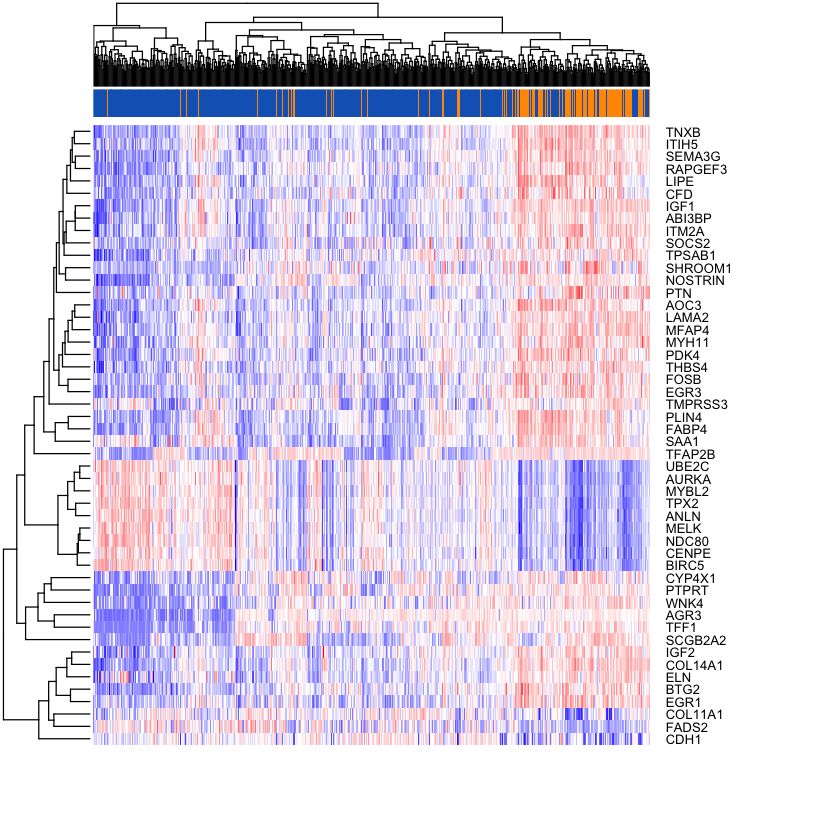

In [202]:
#png(file="fig/heatmap_diff_p_value.png",width=6000,height=6000,res=200)
par(cex.lab=2)
heatmap.2(prob_matrix, na.rm = TRUE,scale='row',margins=c(6,12),
           ColSideColors=clab, symbreaks=FALSE,density.info="none",  key=TRUE,   keysize = 0.5,key.xlab="",key.ylab = 'Density', symkey=FALSE,
          trace="none", labRow=v$genes$gene_name[i],labCol=FALSE, cexRow=1, col=mycol,sepcolor="black",
           sepwidth=c(1,0.1))
legend("bottomright",legend=c("IDC","ILC"), fill=c("#1565C0","#FF9900"), border=FALSE,bty="n",  y.intersp = 1,cex=1,horiz=TRUE)
#dev.off()


### PCA with only DEG

In [ ]:
z <- which(v$genes$gene_name %in% up_regulated$gene_name)

In [ ]:
#prob_matrix2=data.matrix(lcpm[z,])

In [ ]:
second.pca <- prcomp(t(lcpm[z,]), center = TRUE) 

In [ ]:
second.pca$group<-cluster_name

In [ ]:
data_plot2 <- data.frame(second.pca$x[,1], second.pca$x[,2])
colnames(data_plot2)=c('PCA1', 'PCA2')

In [ ]:
data_plot2$group<-cluster_name$group

In [ ]:
data_plot2$cancer_type<-cluster_name$cancer_type

In [ ]:
#png(file="fig/PCA_diff.png",width=1500,height=1000,res=200)
ggplot(data_plot2, aes(x=PCA1, y=PCA2, color=group)) + geom_point()+
ggtitle("") +xlab("PC1")+ ylab("PC2")+
  theme( 
    plot.title = element_text(color="black", size=12, face="bold",hjust =1/2),
    axis.title.x = element_text(color="black", size=10),
    axis.title.y = element_text(color="black", size=10)
  )+theme_bw() +
  scale_color_manual(name="Histologic subtype", labels = c("IDC","ILC"), values = c("IDC"="#3A8EBA", "ILC"="#BB0B0B"))
#dev.off()